# posteriors for $z=0.4$ case

In [1]:
import os
import numpy as np
from scipy.stats import uniform

In [2]:
from provabgs import infer as Infer
from provabgs import models as Models

/home/chhahn/projects/provabgs/src/provabgs/models.py:23: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [3]:
from dusty import util as U
from dusty import data as D

In [4]:
import pocomc as pc

In [5]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [6]:
igal = 64
iang = 0 
ised = 10*igal + iang

In [7]:
filters = U.lsst()

In [8]:
maggies = np.load('/scratch/gpfs/chhahn/dusty/nihao_lsst.v3.z0p4.maggies_nodust.npy')
sig_maggies = np.load('/scratch/gpfs/chhahn/dusty/nihao_lsst.v3.z0p4.sig_maggies_nodust.npy')

In [9]:
# sps model 
m_nmf = Models.NMF(burst=True, emulator=True)

prior = pc.Prior([uniform(loc=7, scale=6),
                  uniform(loc=0., scale=1.),
                  uniform(loc=0., scale=1.),
                  uniform(loc=0., scale=1.),
                  uniform(loc=0., scale=1.),
                  uniform(loc=1e-2, scale=13.26),
                  uniform(loc=np.log10(4.5e-5), scale=np.log10(1.5e-2) - np.log10(4.5e-5)),
                  uniform(loc=np.log10(4.5e-5), scale=np.log10(1.5e-2) - np.log10(4.5e-5)),
                  uniform(loc=0.01, scale=0.59)])

provabgs_prior = Infer.load_priors([
    Infer.UniformPrior(7., 13, label='sed'),
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(1e-2, 13.27, label='sed'), # tburst
    Infer.LogUniformPrior(4.5e-5, 1.5e-2, label='sed'), # log uniform priors on ZH coeff
    Infer.LogUniformPrior(4.5e-5, 1.5e-2, label='sed') # log uniform priors on ZH coeff
])

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [11]:
def log_likelihood(tt):
    photos = model_photo(tt)
    # data - model(theta) for photometry
    dphoto = (photos - maggies[ised])

    # calculate chi-squared for photometry
    chi2 = (-0.5 * np.sum(dphoto**2 / sig_maggies[ised]**2, axis=1))
    return chi2

def model_photo(tt): 
    _theta = tt.copy()[:,:-1]
    _theta[:,6] = 10**_theta[:,6]
    _theta[:,7] = 10**_theta[:,7]
    __theta = provabgs_prior.transform(_theta)
    theta = np.concatenate([__theta, np.tile(np.array([0., 0., -0.7]), (tt.shape[0],1))], axis=1)

    # calculate SED model(theta)
    photos = []
    for _tt, _z in zip(theta, tt[:,-1]):    
        _, _, photo = m_nmf.sed(_tt, _z, filters=filters)
        photos.append(photo)

    return np.array(photos)

In [12]:
_tt = prior.rvs()
print(model_photo(_tt))

[[0.01450663 0.02141963 0.03294841 0.0369143  0.03893399 0.0422877 ]]


In [13]:
# Initialise sampler
sampler = pc.Sampler(
    prior=prior,
    likelihood=log_likelihood,
    vectorize=True,
    random_state=0
)

In [14]:
# Start sampling
sampler.run(progress=True)

Iter: 44it [22:26, 30.61s/it, beta=1, calls=71168, ESS=4079, logZ=-21.5, logP=-9.17, acc=0.284, steps=4, eff=1]         


In [15]:
# Get the results
samples, weights, logl, logp = sampler.posterior()

In [16]:
samples[:,0]

array([11.50837287, 11.50837287, 11.54127716, ..., 11.50759477,
       11.4881117 , 11.50788608])

In [17]:
i_map = np.argmax(logl)

m_photo = model_photo(np.array([samples[i_map]]))

/tmp/ipykernel_3305601/763645331.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  sub.legend(loc='lower right', handletextpad=0.1, fontsize=18)


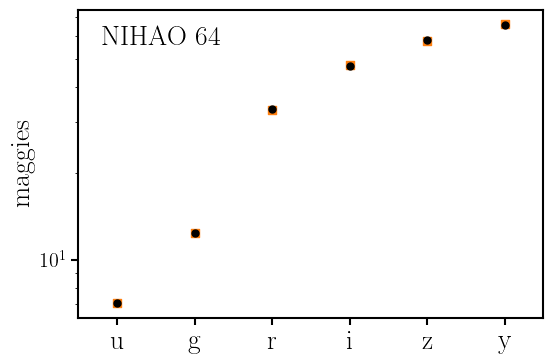

In [18]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

sub.errorbar(np.arange(6), maggies[ised], yerr=sig_maggies[ised], fmt='.k', markersize=10)
sub.scatter(np.arange(6), m_photo, color='C1', marker='s')

sub.text(0.05, 0.95, 'NIHAO %i' % igal, transform=sub.transAxes, ha='left', va='top', fontsize=20)
sub.legend(loc='lower right', handletextpad=0.1, fontsize=18)
sub.set_xlim(-0.5, 5.5)
sub.set_xticks(np.arange(6))
sub.set_xticklabels(['u', 'g', 'r', 'i', 'z', 'y'])
sub.tick_params(axis='x', which='major', labelsize=20)
sub.set_ylabel('maggies', fontsize=20)
sub.set_yscale('log')

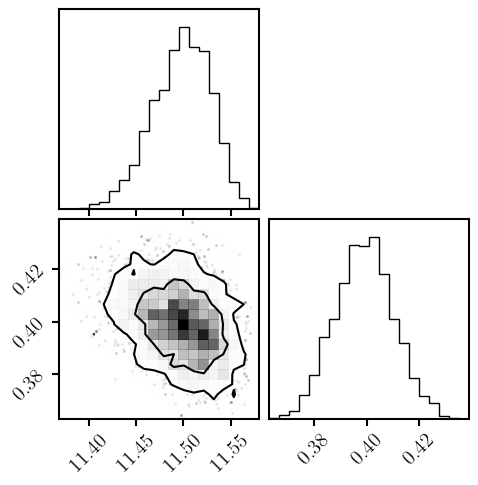

In [19]:
fig = DFM.corner(np.array([samples[:,0], samples[:,-1]]).T, weights=weights, levels=[0.68, 0.95])

In [20]:
from dusty import data as D

In [21]:
# get data
NH = D.Nihao()

In [25]:
np.log10(NH.prop['stellar_mass'][ised])

np.float32(11.505486)